## Assignment 7
#### EP20BTECH11007
#### Gowri Govindaraj

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2
import seaborn as sns
sns.set_theme()
from scipy.stats import norm
import emcee
import corner
from astroML.plotting import plot_mcmc
from sklearn.neighbors import KernelDensity

/Users/gowrigovindaraj/opt/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Q1

In [2]:
data_q1 = pd.read_csv('fgas_spt.txt', sep='\s+')
z = data_q1['#z']
fgas = data_q1['fgas']
fgas_err = data_q1['fgas_error']

In [3]:
def log_likelihood(theta,x,y,yerr):
    m,b = theta
    model = b*(1+m*x)
    sigma2 = yerr**2
    return -0.5*np.sum((y-model)**2/sigma2)

def log_prior(theta):
    m,b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 0.5:
        return 0.0
    return -np.inf

def log_probability(theta,x,y,yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,x,y,yerr)

In [4]:
n_dim = 2
n_walkers = 50
n_burn = 1000
n_steps = 2000

In [5]:
theta_start = np.array([np.random.uniform(-0.5, 0.5, n_walkers), np.random.uniform(0.0, 0.5, n_walkers)]).T

In [6]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[z,fgas,fgas_err])
sampler.run_mcmc(theta_start, n_steps)
samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

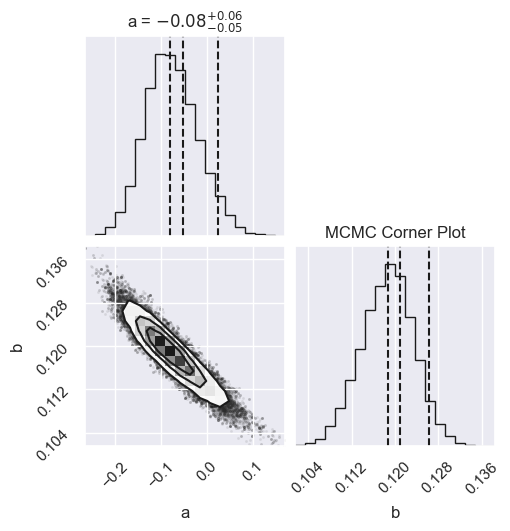

In [7]:
corner.corner(samples, labels=["a", "b", "c"], quantiles=[0.5,0.68, 0.95], show_titles=True, title_kwargs={"fontsize": 12})
plt.title("MCMC Corner Plot")
plt.show()

# fig = plot_mcmc(samples , colors = 'k' , linewidths = [3,3] , alpha = 0.80)
# plt.plot(samples[:,0] , samples[:,1] , 'o' , alpha = 0.02, markeredgecolor = '#1497E5',markerfacecolor = 'skyblue')
# plt.xlim(-0.5 , 0.5)
# plt.ylim(0.05 , 0.15)
# # plt.title("MCMC Trace Plot using plot_mcmc")
# plt.show()


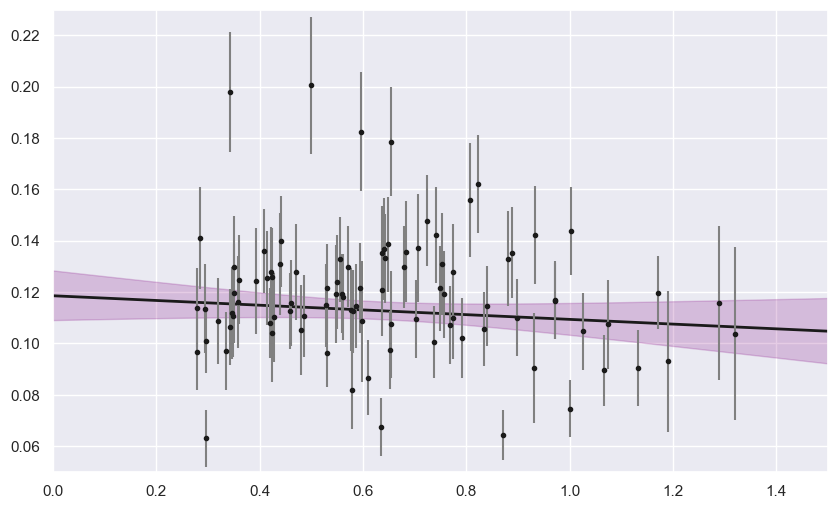

In [18]:
x_val = np.linspace(0, 3, 1000)
m,b = samples.T[:2]
y_val = b[:,None]*(1+m[:,None]*x_val)

y_min = y_val.mean(0)-2*y_val.std(0)
y_max = y_val.mean(0)+2*y_val.std(0)

plt.figure(figsize=(10,6))
plt.plot(x_val, y_val.mean(0), color='k', lw=2)
plt.fill_between(x_val, y_min, y_max, color='purple', alpha=0.2)
plt.errorbar(z, fgas, yerr=fgas_err, fmt='.k', ecolor='gray')
plt.xlim(0,1.5)
plt.ylim(0.05,0.23)
plt.show()

In [11]:
a,p = samples.T[:2]
a,p

(array([-0.08196785, -0.0962288 , -0.0899217 , ..., -0.00231433,
         0.04767617,  0.04600906]),
 array([0.11824182, 0.11878838, 0.1183281 , ..., 0.11296325, 0.10850844,
        0.10897611]))

## Q2

In [35]:
data_q2 = np.array([[0.42,  0.72,  0.,  0.3,  0.15,0.09,  0.19,  0.35,  0.4,  0.54,
                  0.42,  0.69,  0.2,  0.88,  0.03,0.67,  0.42,  0.56,  0.14,  0.2],
                 [0.33,  0.41, -0.22,  0.01, -0.05, -0.05, -0.12,  0.26,  0.29,  0.39,
                  0.31,  0.42, -0.01,  0.58, -0.2, 0.52,  0.15,  0.32, -0.13, -0.09],
                 [0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1,
                  0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1]])

In [43]:
def poly_fit(x,param):
    return sum(t * x ** n for (n, t) in enumerate(param))

def log_likelihood(theta):
    x,y,yerr = data_q2
    model = poly_fit(x,theta)
    sigma2 = yerr**2
    return -0.5*np.sum(np.log(2 * np.pi * sigma2) + (y - model) ** 2 / sigma2)

def prior_transform(theta):
    return theta

In [45]:
x,y,yerr = data_q2

import nestle

linear = nestle.sample(log_likelihood, prior_transform, 2, method='single', npoints=1000, maxiter=1000, update_interval=100)
quadratic = nestle.sample(log_likelihood, prior_transform, 3, method='single', npoints=1000, maxiter=1000, update_interval=100)

print(linear.summary())
print()
print(quadratic.summary())


niter: 1001
ncall: 2338
nsamples: 2000
logz:  3.326 +/-  0.070
h:  4.960

niter: 1001
ncall: 2342
nsamples: 2000
logz:  5.750 +/-  0.075
h:  5.613


## Q3

In [48]:
data_q3 = pd.read_csv('SDSS_quasar.dat.txt', sep='\s+')
z = data_q3['z'].to_list()

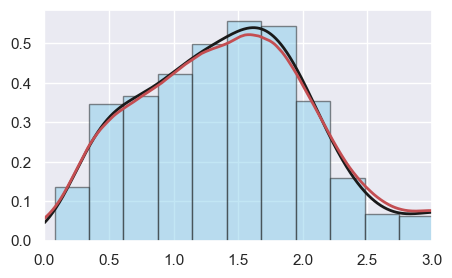

In [52]:
x_val = np.linspace(0, 3, 1000)
gaussian_log_pdf = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(z).reshape(-1, 1)).score_samples(x_val.reshape(-1, 1))
pdf_gaussian = np.exp(gaussian_log_pdf)

exponential_log_pdf = KernelDensity(kernel='exponential', bandwidth=0.2).fit(np.array(z).reshape(-1, 1)).score_samples(x_val.reshape(-1, 1))
pdf_exponential = np.exp(exponential_log_pdf)

plt.figure(figsize=(5,3))
plt.plot(x_val, pdf_gaussian, color='k', lw=2)
plt.plot(x_val, pdf_exponential, color='r', lw=2)
plt.hist(z, bins=20, density=True, color='skyblue', edgecolor='k', alpha=0.5)
plt.xlim(0,3)
plt.show()
